In [1]:
from feature_extractor import FeatureExtractor
import sys
import numpy as np
import h5py
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score,accuracy_score, make_scorer
from sklearn.base import clone
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.utils as np_utils
import os
import joblib
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB


In [2]:
import IPython

%load_ext autoreload
%autoreload 2

In [3]:
# Open the HDF5 file
DATA_FOLDER = Path("w:/")
filepath = DATA_FOLDER / "prediction.seg"
file = h5py.File(filepath, 'r')

# Access the dataset
amplitude_dataset = file['amplitude/images']
phase_dataset = file['phase/images']
label_dataset = file['label/ground_truth']
mask_dataset = file['mask/images']

In [4]:
# Split the data in train and test data and make sure that all classes all represented with the correct ratios

split = 0.8  # 80% used for training

# Get unique labels and their corresponding indices
unique_labels, label_indices = np.unique(label_dataset, return_inverse=True)

# Initialize train and test datasets
phase_dataset_train = []
phase_dataset_test = []
amplitude_dataset_train = []
amplitude_dataset_test = []
mask_dataset_train = []
mask_dataset_test = []
label_train = []
label_test = []

# Iterate over each unique label
for label in range(len(unique_labels)):
    
    # Get indices corresponding to the current label
    label_indices_current = np.where(label_indices == label)[0]

    # Calculate the split index for the current label
    k = int(np.ceil(split * len(label_indices_current)))

    # Create a random permutation of indices for the current label
    indices_current = np.random.permutation(len(label_indices_current))

    # Sort the indices to avoid errors
    indices_train = np.sort(indices_current[:k])
    indices_test = np.sort(indices_current[k:])


    # Assign shuffled data to train and test sets for the current label
    phase_dataset_train.extend(phase_dataset[label_indices_current[indices_train]])
    phase_dataset_test.extend(phase_dataset[label_indices_current[indices_test]])
    amplitude_dataset_train.extend(amplitude_dataset[label_indices_current[indices_train]])
    amplitude_dataset_test.extend(amplitude_dataset[label_indices_current[indices_test]])
    mask_dataset_train.extend(mask_dataset[label_indices_current[indices_train]])
    mask_dataset_test.extend(mask_dataset[label_indices_current[indices_test]])
    label_train.extend(label_dataset[label_indices_current[indices_train]])
    label_test.extend(label_dataset[label_indices_current[indices_test]])

# Convert the train and test datasets to arrays
phase_dataset_train = np.array(phase_dataset_train)
phase_dataset_test = np.array(phase_dataset_test)
amplitude_dataset_train = np.array(amplitude_dataset_train)
amplitude_dataset_test = np.array(amplitude_dataset_test)
mask_dataset_train = np.array(mask_dataset_train)
mask_dataset_test = np.array(mask_dataset_test)
label_train = np.array(label_train)
label_test = np.array(label_test)

In [5]:
# Perform Data Augmentation on the training data. For that we create an instance of the ImageDataGenerator class with specified transformations

datagen = ImageDataGenerator(
    rotation_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)

# Reshape to have a 4D shape (samples, height, width, channels)
phase_data = np.reshape(phase_dataset_train, (phase_dataset_train.shape[0], phase_dataset_train.shape[1], phase_dataset_train.shape[2], 1))
amplitude_data = np.reshape(amplitude_dataset_train, (amplitude_dataset_train.shape[0], amplitude_dataset_train.shape[1], amplitude_dataset_train.shape[2], 1))
mask_data = np.reshape(mask_dataset_train, (mask_dataset_train.shape[0], mask_dataset_train.shape[1], mask_dataset_train.shape[2], 1))

# Help lists
phase_train_pre = []
amplitude_train_pre = []
mask_train_pre = []

seed = 42

for i in range(phase_data.shape[0]):

    seed += 1  # Use a different seed for each pair of images
    batch1_seed = datagen.flow(np.array([phase_data[i]]), batch_size=1, seed=seed).next()[0]
    batch2_seed = datagen.flow(np.array([amplitude_data[i]]), batch_size=1, seed=seed).next()[0]
    batch3_seed = datagen.flow(np.array([mask_data[i]]), batch_size=1, seed=seed).next()[0]
    
    phase_train_pre.append(batch1_seed[:])
    amplitude_train_pre.append(batch2_seed[:])
    mask_train_pre.append(batch3_seed[:])


    if len(phase_train_pre) >= phase_data.shape[0]:
        break

# Convert to arrays
phase_train_pre = np.array(phase_train_pre)
amplitude_train_pre = np.array(amplitude_train_pre)
mask_train_pre = np.array(mask_train_pre)


# Reshape augmented_images back to a 3D shape (samples, height, width)
phase_train_pre = np.reshape(phase_train_pre,(phase_train_pre.shape[0], phase_train_pre.shape[1], phase_train_pre.shape[2]))
amplitude_train_pre = np.reshape(amplitude_train_pre, (amplitude_train_pre.shape[0], amplitude_train_pre.shape[1], amplitude_train_pre.shape[2]))
mask_train_pre = np.reshape(mask_train_pre, (mask_train_pre.shape[0], mask_train_pre.shape[1], mask_train_pre.shape[2]))

In [6]:
# We need to remove NaN values from the images. We replace those values with the minimum non-NaN found in each image

# Replace NaN values in phase train images with the minimum value of each image
phase_train = phase_train_pre
for i, img in enumerate(phase_train):
    if np.isnan(np.min(img)):
        min = np.nanmin(img)
        img[np.isnan(img)] = min

# Replace NaN values in phase test images with the minimum value of each image
phase_test = phase_dataset_test
for i, img in enumerate(phase_test):
    if np.isnan(np.min(img)):
        min = np.nanmin(img)
        img[np.isnan(img)] = min

# Replace NaN values in amplitude train images with the minimum value of each image
amplitude_train = amplitude_train_pre
for i, img in enumerate(amplitude_train):
    if np.isnan(np.min(img)):
        min = np.nanmin(img)
        img[np.isnan(img)] = min

# Replace NaN values in amplitude test images with the minimum value of each image
amplitude_test = amplitude_dataset_test
for i, img in enumerate(amplitude_test):
    if np.isnan(np.min(img)):
        min = np.nanmin(img)
        img[np.isnan(img)] = min

# Replace NaN values in amplitude train images with the minimum value of each image
mask_train = mask_train_pre
for i, img in enumerate(mask_train):
    if np.isnan(np.min(img)):
        min = np.nanmin(img)
        img[np.isnan(img)] = min
    img = np.round(img)

# Convert to avoid errors
mask_train = mask_train.astype(int)
mask_train = np.array(mask_train, dtype=np.uint8)

In [7]:
# Create the dataframes with the features
fe_train = FeatureExtractor(phase_train, amplitude_train, mask_train)
fe_test = FeatureExtractor(phase_test, amplitude_test, mask_dataset_test)

fe_train.extract_features()
fe_test.extract_features()

df_train = fe_train.features
df_test = fe_test.features

# Define Train and test Dataframes
X_train = df_train.copy()
X_test = df_test.copy()
y_train = label_train
y_test = label_test

# Add the labels
df_train['Labels'] = label_train
df_test['Labels'] = label_test

df = pd.concat([df_train, df_test])

X_train.head()

,Volume,Roundness,Opacity,AmplitudeVariance,AmplitudeSkewness,MaxAmplitude,MinAmplitude,DryMassDensity,MaxPhase,MinPhase,...,PhaseSTDLocalSkewness,PhaseSTDLocalKurtosis,PhaseSTDLocalMin,PhaseSTDLocalMax,AmplitudeSTDLocalMean,AmplitudeSTDLocalVariance,AmplitudeSTDLocalSkewness,AmplitudeSTDLocalKurtosis,AmplitudeSTDLocalMin,AmplitudeSTDLocalMax
0,973.097993,0.720798,12.378349,0.000264,-0.085967,0.060963,-0.046510,0.090646,3.471594,-0.214023,...,0.412167,3.013957,0.042228,0.714162,0.009610,0.000018,0.713657,3.182174,0.002552,0.025871
1,51.359727,0.818138,12.503606,0.000179,-0.271602,0.035639,-0.035840,0.104476,1.622203,0.058768,...,0.014878,2.217582,0.104770,0.511550,0.008890,0.000018,0.268389,2.149607,0.001356,0.019723
2,50.648865,0.833062,12.422627,0.000085,0.231464,0.031177,-0.013728,0.146645,2.094139,0.280731,...,-1.293444,4.528489,0.043892,0.443311,0.005977,0.000008,0.608571,2.624206,0.001841,0.013489
3,54.594146,0.813070,12.477203,0.000349,-0.443641,0.048665,-0.053787,0.106332,1.352572,0.026626,...,-0.169598,1.630008,0.045812,0.392673,0.012586,0.000034,1.086705,3.945784,0.004087,0.033577
4,465.661523,0.793100,12.427254,0.000344,0.494143,0.061923,-0.037108,0.088224,2.880538,0.095290,...,0.248077,2.371410,0.036288,0.578067,0.011731,0.000035,1.125451,4.285225,0.001787,0.035351


In [8]:
# Count the number of rows with NaN values. If everything done correctly the output should be 0
rows_with_nan = df.isna().any(axis=1).sum()

# Print the result
print("Number of rows with NaN values:", rows_with_nan)

# Iterate over rows and print column names with NaN values
for index, row in df.iterrows():
    nan_columns = row.index[row.isna()].tolist()
    if len(nan_columns) > 0:
        print(f"NaN values in row {index+1} appear in columns: {nan_columns}, label: {df['Labels'][index+1]}")


Number of rows with NaN values: 0


In [9]:
# Build the Column Transformer
def col_transf(df):
    num_sc = MinMaxScaler()

    pipe= Pipeline(steps=[("MinMaxScaler", num_sc)])

    pred_column = "Labels"

    # Get a list of all columns except the prediction column
    num_feat = df.columns[df.columns != pred_column]

    ct = ColumnTransformer(transformers=[("NumericalTransformer", pipe, num_feat)])

    return ct


In [10]:
# Build SVC Pipeline and return best estimator based on the grid search
def bestSVC(ct, X_train, y_train):

    pip = Pipeline([
    ('ColumnTransformer', ct),
    ('classifier', SVC(max_iter=1000000, probability=True))
    ])

    gs_param = {
    'classifier__kernel' : ['linear', 'rbf', 'sigmoid'],
    'classifier__C' : [0.3, 0.4, 0.5, 0.7, 1.0],
    'classifier__gamma' : [0.004, 0.005, 0.006, 0.01, 0.05, 0.1 ,0.5]
    } 
    
    stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

    gs = GridSearchCV(pip, gs_param, refit=True, cv=stratified)

    gs.fit(X_train, y_train)

    return gs.best_estimator_

In [11]:
# Build Random Forest Pipeline and return best estimator based on the grid search
def bestRFC(ct, X_train, y_train):

    pipe_rfc = Pipeline([
    ('ColumnTransformer', ct),
    ('classifier', RFC(random_state=12))
    ])

    gs_param_rfc = {
        'classifier__n_estimators' : [10, 20, 50],
        'classifier__max_features' : [2, 4, 8, 12],
        'classifier__max_depth' : [4, 10, 16, 20]
    }
    
    stratified_rfc = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

    gs_rfc = GridSearchCV(pipe_rfc, gs_param_rfc, refit=True, cv=stratified_rfc)

    gs_rfc.fit(X_train, y_train)

    return gs_rfc.best_estimator_

In [12]:
# Build kNN Pipeline and return best estimator based on the grid search
def bestKNN(ct, X_train, y_train):

    pipe_knn = Pipeline([
    ('ColumnTransformer', ct),
    ('classifier', KNeighborsClassifier())
    ])

    gs_param_knn = {
        'classifier__n_neighbors' : [2, 3, 5, 7],
        'classifier__weights' : ['uniform', 'distance'],
        'classifier__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
    
    stratified_knn = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

    gs_knn = GridSearchCV(pipe_knn, gs_param_knn, refit=True, cv=stratified_knn)

    gs_knn.fit(X_train, y_train)

    return gs_knn.best_estimator_

In [13]:
def bestNaiveBayes(ct, X_train, y_train):
    
    pip = Pipeline([
        ('ColumnTransformer', ct),
        ('classifier', GaussianNB())
    ])

    gs_param = {}

    stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

    gs = GridSearchCV(pip, gs_param, refit=True, cv=stratified)

    gs.fit(X_train, y_train)

    return gs.best_estimator_

In [14]:
# Return accuracy
def calculate_accuracy(X_train, y_train, X_test, y_test, model):
    acc_train = model.score(X_train, y_train)
    acc_test = model.score(X_test, y_test)
    return acc_train, acc_test

# Return balanced accuracy 
def calculate_bal_accuracy(X_train, y_train, X_test, y_test, model):
    y_pred_train = model.predict(X_train)
    bacc_train = balanced_accuracy_score(y_train, y_pred_train)
    y_pred_test = model.predict(X_test)
    bacc_test = balanced_accuracy_score(y_test, y_pred_test)
    return bacc_train, bacc_test

# Return accuracy with class_weights = true
def calculate_accuracy_w(X_train, y_train, X_test, y_test, model):
    model_w = clone(model)
    model_w["classifier"].set_params(class_weight='balanced')
    model_w.fit(X_train, y_train)
    acc_train_w = model_w.score(X_train,y_train)
    acc_test_w = model_w.score(X_test,y_test)
    return acc_train_w, acc_test_w 

# Return balanced accuracy with class_weights = true
def calculate_bal_accuracy_w(X_train, y_train, X_test, y_test, model):
    model_w = clone(model)
    model_w["classifier"].set_params(class_weight='balanced')
    model_w.fit(X_train, y_train)
    y_pred_train = model_w.predict(X_train)
    bacc_train_w = balanced_accuracy_score(y_train, y_pred_train)
    y_pred_test = model_w.predict(X_test)
    bacc_test_w = balanced_accuracy_score(y_test, y_pred_test)
    return bacc_train_w, bacc_test_w 

In [15]:
# Return the classes in the correct order (important for the confusion matrix)
def unique_labels(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_true = y_test

    # Get unique labels from true and predicted labels
    unique_labels = sorted(set(y_true) | set(y_pred))

    # Print the unique labels in the order they appear
    return unique_labels

In [16]:
# Plot confusion matrices for train and test sets
def plot_confusion(model, X_train, y_train, X_test, y_test):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    labels = unique_labels(model, X_test, y_test)

    # Best estimator classifier on training data
    cm_best_train = confusion_matrix(y_train, model.predict(X_train))
    sns.heatmap(cm_best_train, annot=True,fmt='d', ax=axs[0], cmap='Blues', xticklabels=labels, yticklabels=labels)
    axs[0].set_xlabel('Predicted labels');axs[0].set_ylabel('True labels'); 
    axs[0].set_title('Best estimator classifier on training data')

    # Best estimator classifier on test data
    cm_best_test = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm_best_test, annot=True,fmt='d', ax=axs[1], cmap='Blues', xticklabels=labels, yticklabels=labels)
    axs[1].set_xlabel('Predicted labels');axs[1].set_ylabel('True labels'); 
    axs[1].set_title('Best estimator classifier on test data')

In [17]:
def save_model(model, folder_path, file_name):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    file_path = os.path.join(folder_path, file_name)
    joblib.dump(model, file_path)
    print(f"Model saved at {file_path}")


def load_model(folder_path, file_name):
    file_path = os.path.join(folder_path, file_name)
    if os.path.exists(file_path):
        return joblib.load(file_path)
    else:
        print(f"Model file '{file_path}' does not exist.")
        return None

In [18]:
ct = col_transf(X_train)
svc_model = bestSVC(ct, X_train, y_train)

# Save the model
save_model(svc_model, "../app/backend/pipeline/classification/models", "best_svc_model.pkl")

# Load the model
loaded_svc_model = load_model("../app/backend/pipeline/classification/models", "best_svc_model.pkl")

acc_train, acc_test = calculate_accuracy(X_train, y_train, X_test, y_test, loaded_svc_model)
bacc_train, bacc_test = calculate_bal_accuracy(X_train, y_train, X_test, y_test, loaded_svc_model)
acc_train_w, acc_test_w = calculate_accuracy_w(X_train, y_train, X_test, y_test, loaded_svc_model)
bacc_train_w, bacc_test_w = calculate_bal_accuracy_w(X_train, y_train, X_test, y_test, loaded_svc_model)

print(f"\nAccuracy on the train set: {acc_train}")
print(f"Accuracy on the test set: {acc_test}")

print(f"\nBalanced Accuracy on the train set best SVC: {bacc_train}")
print(f"Balanced Accuracy on the test set best SVC: {bacc_test}")

print(f"\nAccuracy on the train set (class weights): {acc_train_w}")
print(f"Accuracy on the test (class weights): {acc_test_w}")

print(f"\nBalanced Accuracy on the train set (class weights): {bacc_train_w}")
print(f"Balanced Accuracy on the test set (class weights): {bacc_test_w}")

Model saved at ../app/backend/pipeline/classification/models\best_svc_model.pkl

Accuracy on the train set: 0.9444444444444444
Accuracy on the test set: 0.9523809523809523

Balanced Accuracy on the train set best SVC: 0.9337301587301587
Balanced Accuracy on the test set best SVC: 0.95

Accuracy on the train set (class weights): 0.9555555555555556
Accuracy on the test (class weights): 0.9523809523809523

Balanced Accuracy on the train set (class weights): 0.955952380952381
Balanced Accuracy on the test set (class weights): 0.95


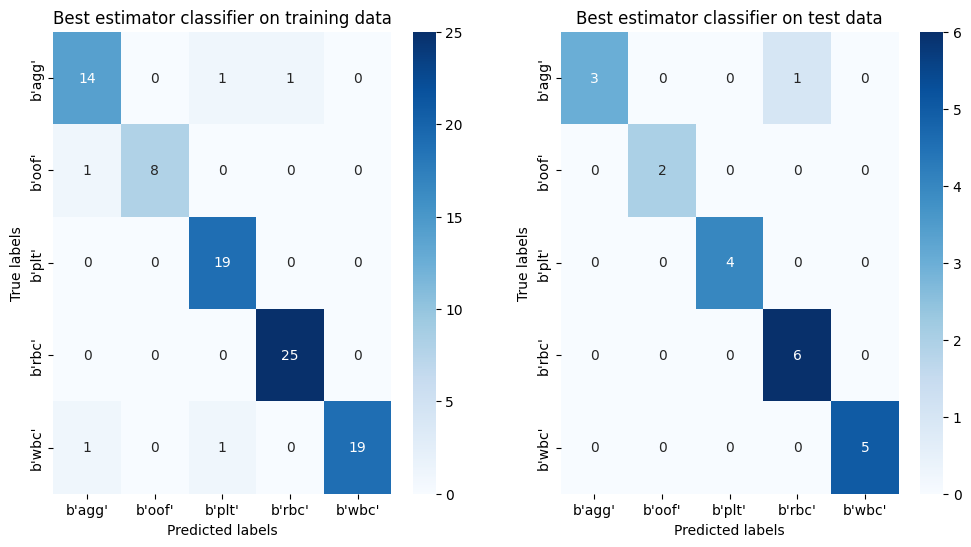

In [19]:
plot_confusion(svc_model, X_train, y_train, X_test, y_test)

In [20]:
# Calculate precision, recall, and F1-score for each class
y_pred = svc_model.predict(X_test)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

classes = unique_labels(svc_model, X_test, y_test)

# Print the metrics for each class
for i in range(5):
    print(f"{classes[i]}")
    print(f"  Precision: {precision[i]}")
    print(f"  Recall: {recall[i]}")
    print(f"  F1-score: {f1[i]}")
    print()

b'agg'
  Precision: 1.0
  Recall: 0.75
  F1-score: 0.8571428571428571

b'oof'
  Precision: 1.0
  Recall: 1.0
  F1-score: 1.0

b'plt'
  Precision: 1.0
  Recall: 1.0
  F1-score: 1.0

b'rbc'
  Precision: 0.8571428571428571
  Recall: 1.0
  F1-score: 0.923076923076923

b'wbc'
  Precision: 1.0
  Recall: 1.0
  F1-score: 1.0



In [21]:
ct = col_transf(X_train)
rfc_model = bestRFC(ct, X_train, y_train)

# Save the model
save_model(rfc_model, "../app/backend/pipeline/classification/models", "best_rfc_model.pkl")

# Load the model
loaded_rfc_model = load_model("../app/backend/pipeline/classification/models", "best_rfc_model.pkl")

acc_train, acc_test = calculate_accuracy(X_train, y_train, X_test, y_test, loaded_rfc_model)
bacc_train, bacc_test = calculate_bal_accuracy(X_train, y_train, X_test, y_test, loaded_rfc_model)
acc_train_w, acc_test_w = calculate_accuracy_w(X_train, y_train, X_test, y_test, loaded_rfc_model)
bacc_train_w, bacc_test_w = calculate_bal_accuracy_w(X_train, y_train, X_test, y_test, loaded_rfc_model)

print(f"\nAccuracy on the train set: {acc_train}")
print(f"Accuracy on the test set: {acc_test}")

print(f"\nBalanced Accuracy on the train set best SVC: {bacc_train}")
print(f"Balanced Accuracy on the test set best SVC: {bacc_test}")

print(f"\nAccuracy on the train set (class weights): {acc_train_w}")
print(f"Accuracy on the test (class weights): {acc_test_w}")

print(f"\nBalanced Accuracy on the train set (class weights): {bacc_train_w}")
print(f"Balanced Accuracy on the test set (class weights): {bacc_test_w}")

Model saved at ../app/backend/pipeline/classification/models\best_rfc_model.pkl

Accuracy on the train set: 0.9666666666666667
Accuracy on the test set: 0.9047619047619048

Balanced Accuracy on the train set best SVC: 0.9654761904761905
Balanced Accuracy on the test set best SVC: 0.9

Accuracy on the train set (class weights): 0.9777777777777777
Accuracy on the test (class weights): 0.9047619047619048

Balanced Accuracy on the train set (class weights): 0.9779761904761906
Balanced Accuracy on the test set (class weights): 0.9


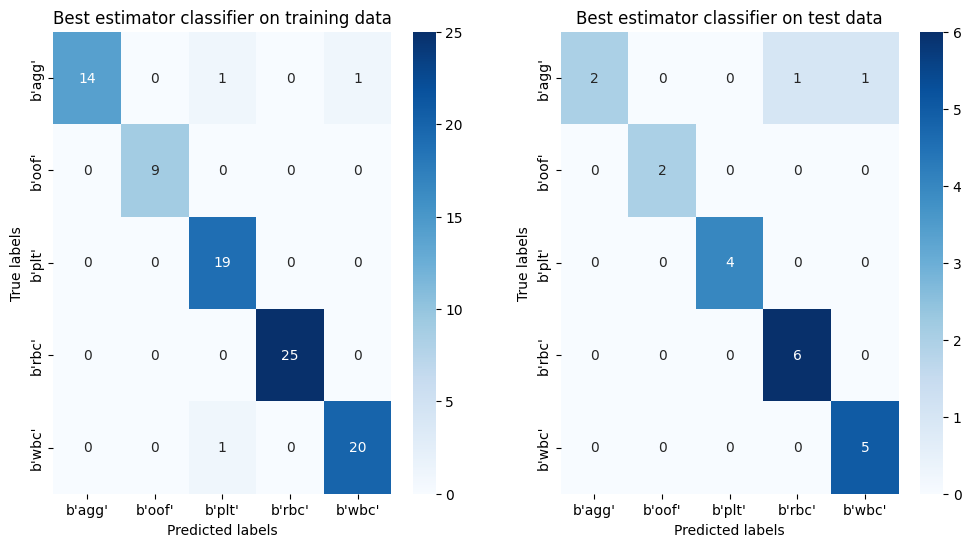

In [22]:
plot_confusion(rfc_model, X_train, y_train, X_test, y_test)

In [23]:
# Calculate precision, recall, and F1-score for each class
y_pred = rfc_model.predict(X_test)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

classes = unique_labels(rfc_model, X_test, y_test)

# Print the metrics for each class
for i in range(5):
    print(f"{classes[i]}")
    print(f"  Precision: {precision[i]}")
    print(f"  Recall: {recall[i]}")
    print(f"  F1-score: {f1[i]}")
    print()

b'agg'
  Precision: 1.0
  Recall: 0.5
  F1-score: 0.6666666666666666

b'oof'
  Precision: 1.0
  Recall: 1.0
  F1-score: 1.0

b'plt'
  Precision: 1.0
  Recall: 1.0
  F1-score: 1.0

b'rbc'
  Precision: 0.8571428571428571
  Recall: 1.0
  F1-score: 0.923076923076923

b'wbc'
  Precision: 0.8333333333333334
  Recall: 1.0
  F1-score: 0.9090909090909091



In [24]:
ct = col_transf(X_train)
knn_model = bestKNN(ct, X_train, y_train)

# Save the model
save_model(knn_model, "../app/backend/pipeline/classification/models", "best_knn_model.pkl")

# Load the model
loaded_knn_model = load_model("../app/backend/pipeline/classification/models", "best_knn_model.pkl")

acc_train, acc_test = calculate_accuracy(X_train, y_train, X_test, y_test, loaded_knn_model)
bacc_train, bacc_test = calculate_bal_accuracy(X_train, y_train, X_test, y_test, loaded_knn_model)

print(f"\nAccuracy on the train set: {acc_train}")
print(f"Accuracy on the test set: {acc_test}")

print(f"\nBalanced Accuracy on the train set best SVC: {bacc_train}")
print(f"Balanced Accuracy on the test set best SVC: {bacc_test}")

Model saved at ../app/backend/pipeline/classification/models\best_knn_model.pkl

Accuracy on the train set: 1.0
Accuracy on the test set: 0.9047619047619048

Balanced Accuracy on the train set best SVC: 1.0
Balanced Accuracy on the test set best SVC: 0.9099999999999999


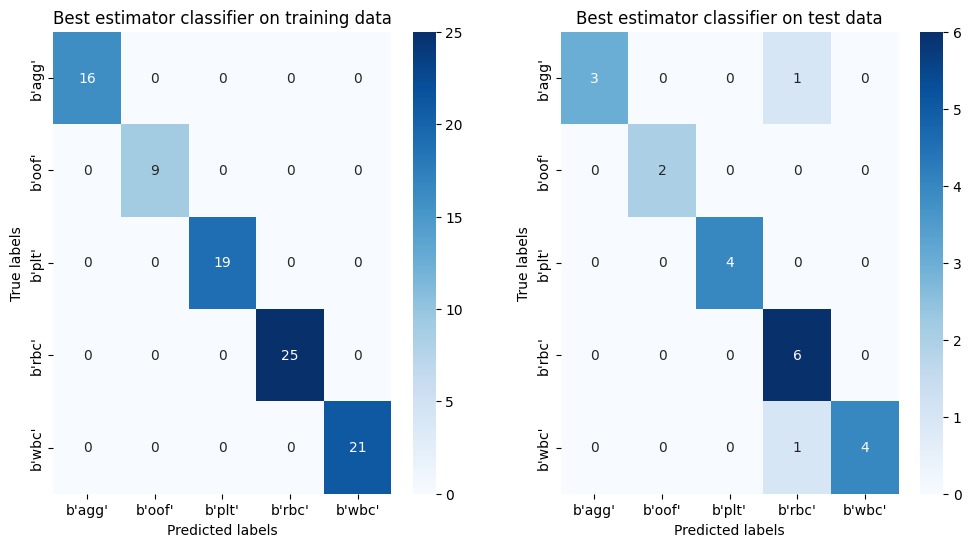

In [25]:
plot_confusion(knn_model, X_train, y_train, X_test, y_test)

In [26]:
# Calculate precision, recall, and F1-score for each class
y_pred = knn_model.predict(X_test)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

classes = unique_labels(knn_model, X_test, y_test)

# Print the metrics for each class
for i in range(5):
    print(f"{classes[i]}")
    print(f"  Precision: {precision[i]}")
    print(f"  Recall: {recall[i]}")
    print(f"  F1-score: {f1[i]}")
    print()

b'agg'
  Precision: 1.0
  Recall: 0.75
  F1-score: 0.8571428571428571

b'oof'
  Precision: 1.0
  Recall: 1.0
  F1-score: 1.0

b'plt'
  Precision: 1.0
  Recall: 1.0
  F1-score: 1.0

b'rbc'
  Precision: 0.75
  Recall: 1.0
  F1-score: 0.8571428571428571

b'wbc'
  Precision: 1.0
  Recall: 0.8
  F1-score: 0.888888888888889



In [27]:
ct = col_transf(X_train)
nb_model = bestNaiveBayes(ct, X_train, y_train)

# Save the model
save_model(nb_model, "../app/backend/pipeline/classification/models", "best_nb_model.pkl")

# Load the model
loaded_nb_model = load_model("../app/backend/pipeline/classification/models", "best_nb_model.pkl")

acc_train, acc_test = calculate_accuracy(X_train, y_train, X_test, y_test, loaded_nb_model)
bacc_train, bacc_test = calculate_bal_accuracy(X_train, y_train, X_test, y_test, loaded_nb_model)

print(f"\nAccuracy on the train set: {acc_train}")
print(f"Accuracy on the test set: {acc_test}")

print(f"\nBalanced Accuracy on the train set best SVC: {bacc_train}")
print(f"Balanced Accuracy on the test set best SVC: {bacc_test}")

Model saved at ../app/backend/pipeline/classification/models\best_nb_model.pkl

Accuracy on the train set: 0.9333333333333333
Accuracy on the test set: 0.9047619047619048

Balanced Accuracy on the train set best SVC: 0.9212301587301587
Balanced Accuracy on the test set best SVC: 0.9


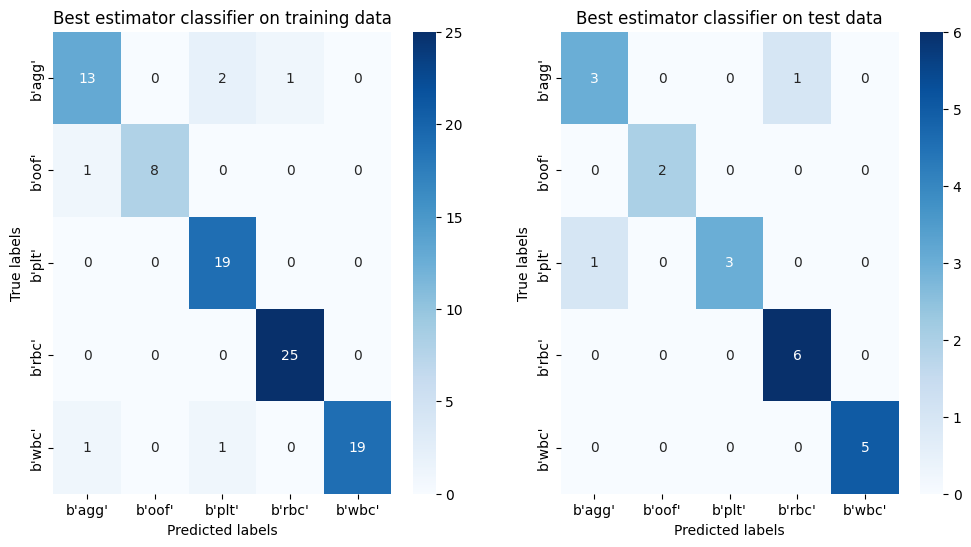

In [28]:
plot_confusion(nb_model, X_train, y_train, X_test, y_test)

In [29]:
# Calculate precision, recall, and F1-score for each class
y_pred = nb_model.predict(X_test)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

classes = unique_labels(nb_model, X_test, y_test)

# Print the metrics for each class
for i in range(5):
    print(f"{classes[i]}")
    print(f"  Precision: {precision[i]}")
    print(f"  Recall: {recall[i]}")
    print(f"  F1-score: {f1[i]}")
    print()

b'agg'
  Precision: 0.75
  Recall: 0.75
  F1-score: 0.75

b'oof'
  Precision: 1.0
  Recall: 1.0
  F1-score: 1.0

b'plt'
  Precision: 1.0
  Recall: 0.75
  F1-score: 0.8571428571428571

b'rbc'
  Precision: 0.8571428571428571
  Recall: 1.0
  F1-score: 0.923076923076923

b'wbc'
  Precision: 1.0
  Recall: 1.0
  F1-score: 1.0



## Compare X_test to the the unlabeled data

In [54]:
import pickle

# Open the .pkl file in read-binary mode
with open("../app/backend/pipeline/classification/models/best_nb_model.pkl", "rb") as file:
    # Load the contents of the .pkl file
    data = pickle.load(file)

# View the loaded contents
print(data[0])

Volume


In [55]:
print(loaded_nb_model)

Pipeline(steps=[('ColumnTransformer',
                 ColumnTransformer(transformers=[('NumericalTransformer',
                                                  Pipeline(steps=[('MinMaxScaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Volume', 'Roundness', 'Opacity', 'AmplitudeVariance',
       'AmplitudeSkewness', 'MaxAmplitude', 'MinAmplitude', 'DryMassDensity',
       'MaxPhase', 'MinPhase', 'PhaseVariance', 'PhaseSkewness',
       'PhaseSTDLocalMean', 'PhaseST...'PhaseSTDLocalSkewness',
       'PhaseSTDLocalKurtosis', 'PhaseSTDLocalMin', 'PhaseSTDLocalMax',
       'AmplitudeSTDLocalMean', 'AmplitudeSTDLocalVariance',
       'AmplitudeSTDLocalSkewness', 'AmplitudeSTDLocalKurtosis',
       'AmplitudeSTDLocalMin', 'AmplitudeSTDLocalMax'],
      dtype='object'))])),
                ('classifier',
                 SVC(C=0.5, gamma=0.004, kernel='linear', max_iter=1000000,
            